In [28]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [29]:
BATCH_SIZE = 4
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [30]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "suduko",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 43 files belonging to 3 classes.


In [31]:

class_names = dataset.class_names
class_names


['one', 'two', 'zero']

In [32]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(4, 256, 256, 3)
[0 0 0 1]


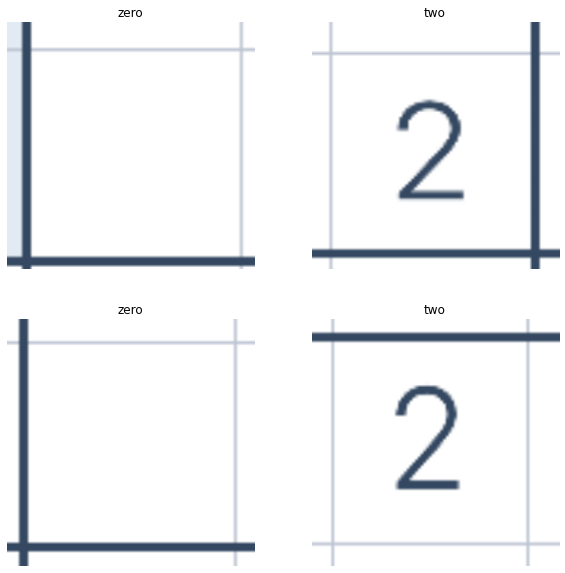

In [33]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    batch_size = len(image_batch)  # Get the batch size dynamically
    for i in range(batch_size):
        ax = plt.subplot(2, batch_size//2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
plt.show()

In [34]:
len(dataset)

11

In [35]:
train_size = 0.8
len(dataset)*train_size

8.8

In [36]:
test_ds = dataset.skip(8)
len(test_ds)

3

In [37]:
val_size=0.1
len(dataset)*val_size


1.1

In [38]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [39]:
test_ds = test_ds.skip(1)
len(test_ds)

2

In [40]:
batch_size = 5

In [41]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [42]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [43]:
len(train_ds), len(val_ds), len(test_ds)

(8, 1, 2)

In [44]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [46]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [47]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [48]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (4, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (4, 254, 254, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (4, 127, 127, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (4, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (4, 62, 62, 64)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (4, 60, 60, 64)          

In [50]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [51]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
8/8 [==============================] - 5s 384ms/step - loss: 1.1457 - accuracy: 0.3750 - val_loss: 1.1219 - val_accuracy: 0.2500
Epoch 2/50
8/8 [==============================] - 2s 306ms/step - loss: 1.0985 - accuracy: 0.3125 - val_loss: 1.1053 - val_accuracy: 0.0000e+00
Epoch 3/50
8/8 [==============================] - 3s 362ms/step - loss: 1.1003 - accuracy: 0.3438 - val_loss: 1.1100 - val_accuracy: 0.0000e+00
Epoch 4/50
8/8 [==============================] - 3s 313ms/step - loss: 1.0992 - accuracy: 0.1875 - val_loss: 1.1022 - val_accuracy: 0.5000
Epoch 5/50
8/8 [==============================] - 2s 306ms/step - loss: 1.0972 - accuracy: 0.3438 - val_loss: 1.1057 - val_accuracy: 0.0000e+00
Epoch 6/50
8/8 [==============================] - 2s 296ms/step - loss: 1.0936 - accuracy: 0.3438 - val_loss: 1.1098 - val_accuracy: 0.0000e+00
Epoch 7/50
8/8 [==============================] - 3s 336ms/step - loss: 1.0817 - accuracy: 0.3438 - val_loss: 1.1079 - val_accuracy: 0.0000e+00


In [64]:
scores = model.evaluate(test_ds, verbose=0)
scores

[2.2169690132141113, 0.625]

In [53]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 8}

In [54]:
history.history['loss'][:5]

[1.1456795930862427,
 1.0984623432159424,
 1.1002870798110962,
 1.099225640296936,
 1.0972015857696533]

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

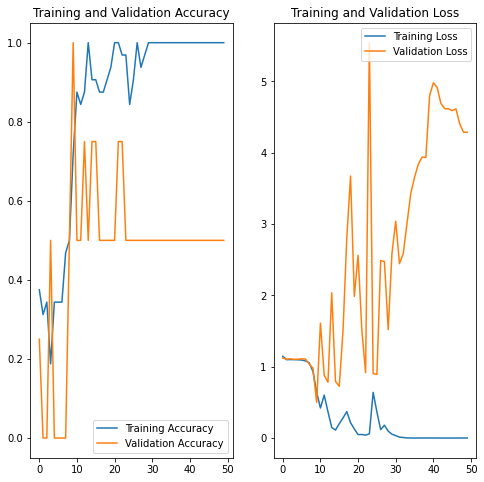

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

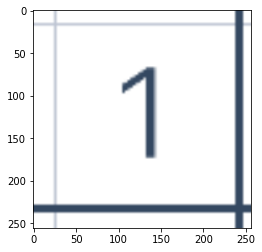

In [67]:
for image_batch, labels_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

first image to predict
actual label: two
1/1 [==============================] - 0s 85ms/step
predicted label: one


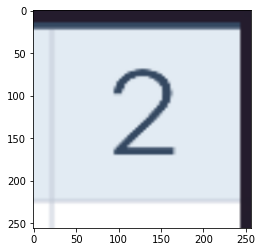

In [77]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[3].numpy().astype('uint8')
    first_label = labels_batch[3].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [58]:
len

<function len(obj, /)>